<a href="https://colab.research.google.com/github/RavimalRanathunga/Eleczone_CNN/blob/main/CNN_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing required libraries

In [ ]:
import torch
import torchvision

###Find mean and standard deviation to Normalize the dataset

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = torchvision.datasets.MNIST(root='./test', train=True, download=True,transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./test', train=False, download=True,transform=transform)

mnist_full_test = ConcatDataset([mnist_train, mnist_test])
print(mnist_full_test[0][0].shape)
x = torch.stack([sample[0] for sample in mnist_full_test])

mean = torch.mean(x,dim=(0,2,3))
std = torch.std(x,dim=(0,2,3))

print(mean)
print(std)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


torch.Size([1, 28, 28])
tensor([0.1309])
tensor([0.3084])


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1309,), (0.3084,))
])

###Import dataset

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 119kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.41MB/s]


In [ ]:
from torch.utils.data import ConcatDataset

mnist_full = ConcatDataset([mnist_train, mnist_test])

In [ ]:
print(f"Shape of the concatenated dataset: {len(mnist_full)}")

Shape of the concatenated dataset: 70000


###Train, Validation and Test split

In [ ]:
from torch.utils.data import random_split

# Define the split sizes
total_size = len(mnist_full)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
mnist_train_split, mnist_val_split, mnist_test_split = random_split(
    mnist_full, [train_size, val_size, test_size]
)

print(f"Training set size: {len(mnist_train_split)}")
print(f"Validation set size: {len(mnist_val_split)}")
print(f"Test set size: {len(mnist_test_split)}")

Training set size: 49000
Validation set size: 10500
Test set size: 10500


###Define the Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

###Utility functions

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([transform(img) for img in images])
    labels = torch.tensor(labels)
    return images, labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###Train loader

In [ ]:
train_loader = DataLoader(mnist_train_split, batch_size=128, shuffle=True, collate_fn=collate_fn)

###Training loop with Adam optimizer

Epoch [1/20], Step [100/383], Average Loss for 100 samples: 0.5441
Epoch [1/20], Step [200/383], Average Loss for 100 samples: 0.1786
Epoch [1/20], Step [300/383], Average Loss for 100 samples: 0.1415
Epoch [1/20], Training Loss: 95.6677
Epoch [1/20], Validation Loss: 4.8900, Validation Accuracy: 97.97%
Epoch [2/20], Step [100/383], Average Loss for 100 samples: 0.0928
Epoch [2/20], Step [200/383], Average Loss for 100 samples: 0.0863
Epoch [2/20], Step [300/383], Average Loss for 100 samples: 0.0941
Epoch [2/20], Training Loss: 34.0219
Epoch [2/20], Validation Loss: 3.3635, Validation Accuracy: 98.70%
Epoch [3/20], Step [100/383], Average Loss for 100 samples: 0.0663
Epoch [3/20], Step [200/383], Average Loss for 100 samples: 0.0668
Epoch [3/20], Step [300/383], Average Loss for 100 samples: 0.0729
Epoch [3/20], Training Loss: 26.3887
Epoch [3/20], Validation Loss: 3.3639, Validation Accuracy: 98.65%
Epoch [4/20], Step [100/383], Average Loss for 100 samples: 0.0492
Epoch [4/20], Step

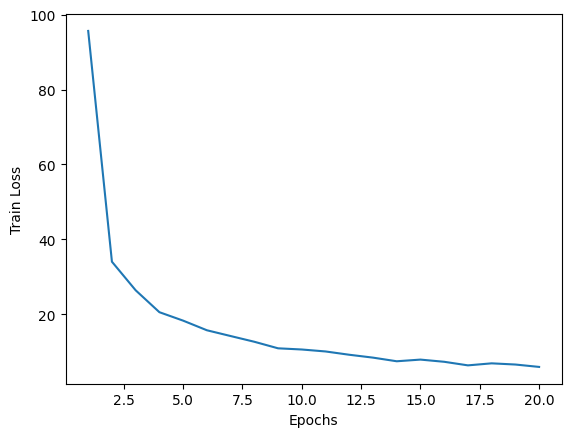

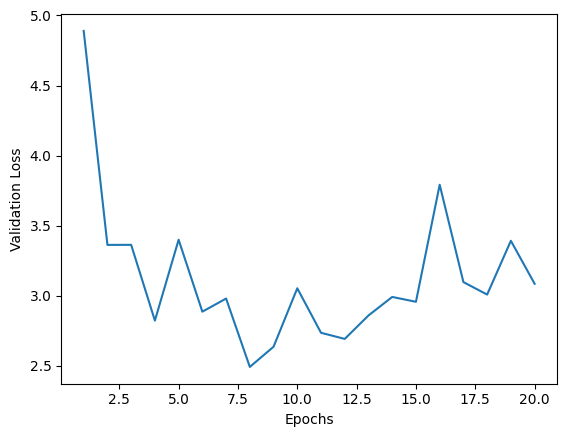

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the number of training epochs
num_epochs = 20

# Define optimizer and loss function
model = Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []
# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model.train()
    running_loss = 0.0
    total_train_loss = 0.0
    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss.append(total_train_loss)

    # Add validation loop after the training loop for each epoch
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0
    # Create a DataLoader for the validation set
    val_loader = DataLoader(mnist_val_split, batch_size=128, shuffle=False, collate_fn=collate_fn)
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_val_loss = total_val_loss
    val_loss.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished.")

plt.plot(range(1, num_epochs + 1), train_loss)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

plt.plot(range(1,num_epochs + 1), val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

### Training loop with standard SGD optimizer

Epoch [1/20], Step [100/383], Average Loss for 100 samples: 1.4064
Epoch [1/20], Step [200/383], Average Loss for 100 samples: 0.5899
Epoch [1/20], Step [300/383], Average Loss for 100 samples: 0.4598
Epoch [1/20], Training Loss: 280.5175
Epoch [1/20], Validation Loss: 23.2549, Validation Accuracy: 91.61%
Epoch [2/20], Step [100/383], Average Loss for 100 samples: 0.3734
Epoch [2/20], Step [200/383], Average Loss for 100 samples: 0.3518
Epoch [2/20], Step [300/383], Average Loss for 100 samples: 0.3397
Epoch [2/20], Training Loss: 133.5855
Epoch [2/20], Validation Loss: 16.8880, Validation Accuracy: 93.84%
Epoch [3/20], Step [100/383], Average Loss for 100 samples: 0.3024
Epoch [3/20], Step [200/383], Average Loss for 100 samples: 0.2775
Epoch [3/20], Step [300/383], Average Loss for 100 samples: 0.2726
Epoch [3/20], Training Loss: 107.4686
Epoch [3/20], Validation Loss: 14.9072, Validation Accuracy: 94.50%
Epoch [4/20], Step [100/383], Average Loss for 100 samples: 0.2505
Epoch [4/20]

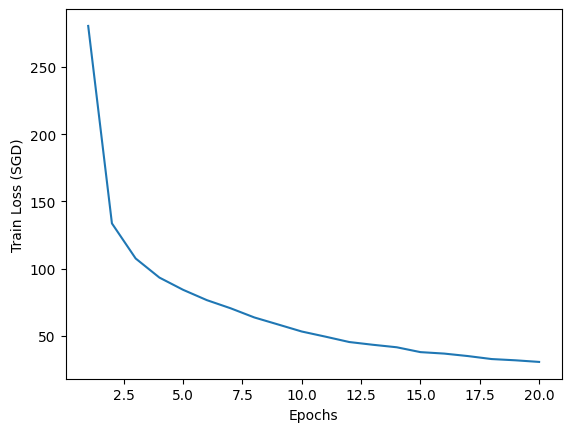

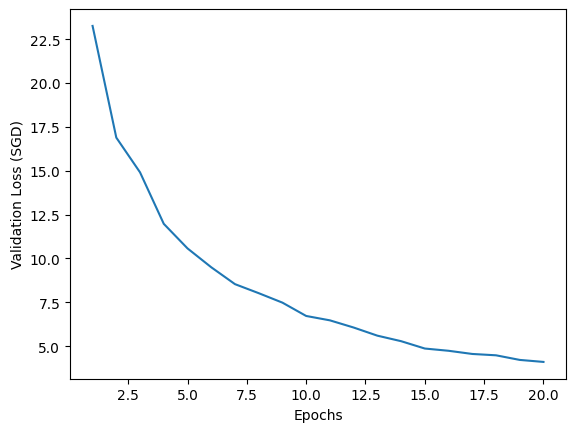

In [ ]:
# Define optimizer and loss function for standard SGD
model_sgd = Net().to(device)
criterion_sgd = nn.NLLLoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

train_loss_sgd = []
val_loss_sgd = []

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd.train()
    running_loss = 0.0
    total_train_loss = 0.0
    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd.append(total_train_loss)

    # Add validation loop after the training loop for each epoch
    model_sgd.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0
    # Create a DataLoader for the validation set
    val_loader = DataLoader(mnist_val_split, batch_size=128, shuffle=False, collate_fn=collate_fn)
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd(images)
            loss = criterion_sgd(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_val_loss = total_val_loss
    val_loss_sgd.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD.")

plt.plot(range(1, num_epochs + 1), train_loss_sgd)
plt.xlabel("Epochs")
plt.ylabel("Train Loss (SGD)")
plt.show()

plt.plot(range(1,num_epochs + 1), val_loss_sgd)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (SGD)")
plt.show()

### Training loop with SGD with momentum optimizer

Epoch [1/20], Step [100/383], Average Loss for 100 samples: 0.8972
Epoch [1/20], Step [200/383], Average Loss for 100 samples: 0.3668
Epoch [1/20], Step [300/383], Average Loss for 100 samples: 0.2530
Epoch [1/20], Training Loss: 168.9679
Epoch [1/20], Validation Loss: 8.6712, Validation Accuracy: 96.54%
Epoch [2/20], Step [100/383], Average Loss for 100 samples: 0.1526
Epoch [2/20], Step [200/383], Average Loss for 100 samples: 0.1461
Epoch [2/20], Step [300/383], Average Loss for 100 samples: 0.1257
Epoch [2/20], Training Loss: 52.6632
Epoch [2/20], Validation Loss: 5.2019, Validation Accuracy: 98.05%
Epoch [3/20], Step [100/383], Average Loss for 100 samples: 0.0971
Epoch [3/20], Step [200/383], Average Loss for 100 samples: 0.1046
Epoch [3/20], Step [300/383], Average Loss for 100 samples: 0.0977
Epoch [3/20], Training Loss: 37.6794
Epoch [3/20], Validation Loss: 4.4923, Validation Accuracy: 98.20%
Epoch [4/20], Step [100/383], Average Loss for 100 samples: 0.0783
Epoch [4/20], Ste

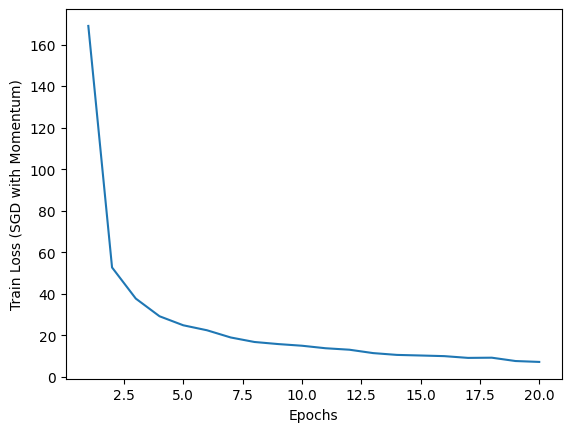

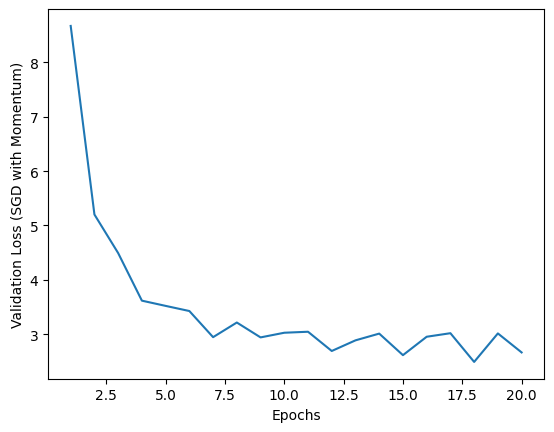

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum = Net().to(device)
criterion_sgd_momentum = nn.NLLLoss()
optimizer_sgd_momentum = optim.SGD(model_sgd_momentum.parameters(), lr=0.01, momentum=0.9)

train_loss_sgd_momentum = []
val_loss_sgd_momentum = []

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum.train()
    running_loss = 0.0
    total_train_loss = 0.0
    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0
    # Create a DataLoader for the validation set
    val_loader = DataLoader(mnist_val_split, batch_size=128, shuffle=False, collate_fn=collate_fn)
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum(images)
            loss = criterion_sgd_momentum(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum.")

plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum)
plt.xlabel("Epochs")
plt.ylabel("Train Loss (SGD with Momentum)")
plt.show()

plt.plot(range(1,num_epochs + 1), val_loss_sgd_momentum)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (SGD with Momentum)")
plt.show()

### Evaluate Model Performance on test set

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

# Create a DataLoader for the test set
test_loader = DataLoader(mnist_test_split, batch_size=128, shuffle=False, collate_fn=collate_fn)

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, cm

print("Evaluating model with Adam optimizer:")
accuracy_adam, precision_adam, recall_adam, cm_adam = evaluate_model(model, test_loader, device)
print(f"Accuracy: {accuracy_adam:.4f}")
print(f"Precision (macro): {precision_adam:.4f}")
print(f"Recall (macro): {recall_adam:.4f}")
print("Confusion Matrix:")
print(cm_adam)

print("\nEvaluating model with standard SGD optimizer:")
accuracy_sgd, precision_sgd, recall_sgd, cm_sgd = evaluate_model(model_sgd, test_loader, device)
print(f"Accuracy: {accuracy_sgd:.4f}")
print(f"Precision (macro): {precision_sgd:.4f}")
print(f"Recall (macro): {recall_sgd:.4f}")
print("Confusion Matrix:")
print(cm_sgd)

print("\nEvaluating model with SGD with momentum optimizer:")
accuracy_sgd_momentum, precision_sgd_momentum, recall_sgd_momentum, cm_sgd_momentum = evaluate_model(model_sgd_momentum, test_loader, device)
print(f"Accuracy: {accuracy_sgd_momentum:.4f}")
print(f"Precision (macro): {precision_sgd_momentum:.4f}")
print(f"Recall (macro): {recall_sgd_momentum:.4f}")
print("Confusion Matrix:")
print(cm_sgd_momentum)

Evaluating model with Adam optimizer:
Accuracy: 0.9921
Precision (macro): 0.9920
Recall (macro): 0.9920
Confusion Matrix:
[[1019    0    2    0    0    0    2    0    3    1]
 [   0 1215    3    0    0    0    0    0    1    0]
 [   1    0 1067    0    0    0    0    3    2    1]
 [   0    1    5 1051    0    3    0    3    2    0]
 [   0    0    1    0 1003    0    0    1    3    8]
 [   3    0    0    1    0  945    1    0    1    0]
 [   0    1    0    0    1    1 1035    0    2    0]
 [   0    1    1    0    2    0    0 1094    1    6]
 [   1    0    3    0    1    0    1    1  966    1]
 [   1    0    0    0    1    1    0    2    2 1022]]

Evaluating model with standard SGD optimizer:
Accuracy: 0.9854
Precision (macro): 0.9856
Recall (macro): 0.9852
Confusion Matrix:
[[1024    0    0    0    0    0    1    1    0    1]
 [   0 1212    5    0    1    0    0    1    0    0]
 [   2    5 1055    1    1    0    0    6    4    0]
 [   0    0   12 1037    0    0    0    6    8    2]
 [  